## Part 1 Inspecting and selecting working light curve

* [exoplanet.eu](http://exoplanet.eu/catalog/CoRoT-5_b/)

Created: 10/20/2017

Last run:
* 10/20

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*.dat')
file_list.sort()
len(file_list)

3

In [5]:
file_list[0]

'./msct0-HAT-P-12-170429-r18.0-t1-c2.dat'

## import lc

In [6]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=' ', parse_dates=True)
    df.columns='GJD-2450000,flux,err,airmass,sky,dx,dy,baserun,dummy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    df['GJD'] = df['GJD-2450000'].apply(lambda x: x+2450000)
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    try:
        df=df.drop(['dummy','baserun'],1)
    except:
        pass
    data[b]=df

In [7]:
df.head()

,GJD-2450000,flux,err,airmass,sky,dx,dy
GJD,,,,,,,
2.457873e+06,7873.120851,1.003429,0.001679,1.0149,207.8,6.066,15.425
2.457873e+06,7873.121476,1.005263,0.001684,1.0151,203.3,5.521,15.945
2.457873e+06,7873.122101,1.002359,0.001680,1.0154,202.2,5.527,16.393
2.457873e+06,7873.122737,1.000947,0.001686,1.0156,212.0,4.814,16.820
2.457873e+06,7873.123362,1.003316,0.001695,1.0159,214.3,4.652,17.267


In [8]:
data[b].columns

Index(['GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

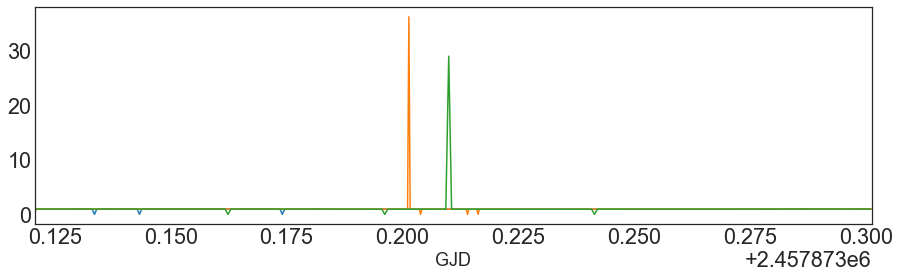

In [9]:
fig,ax = pl.subplots(1,1,figsize=(15,4))
for b in sorted(bands):
    df=data[b]
    df.flux.plot(label=b, ax=ax)

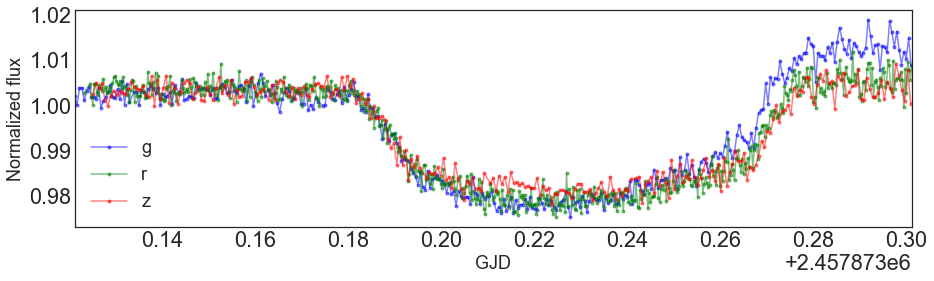

In [13]:
from astropy.stats import sigma_clip

outliers = {}
data2    = {} #outliers removed

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    #determine outliers
    fc = sigma_clip(df.flux, sigma_lower=5, sigma_upper=3)
    xc = sigma_clip(df.dx, sigma_lower=5, sigma_upper=3)
    yc = sigma_clip(df.dy, sigma_lower=10, sigma_upper=3)
    outliers[b] = (xc.mask | yc.mask | fc.mask)
    #remove outliers
    df2 = df[~outliers[b]]
    data2[b] = df2
    df2.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

## Save

In [14]:
for b in sorted(bands):
    fname='hatp12_QL_{}-band.csv'.format(b)
    data2[b].to_csv(fname)